In [2]:
#Import Statements
import tensorflow as tf
from keras.models import Sequential # type: ignore
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from keras.optimizers import Adam # type: ignore
import numpy as np  # type: ignore # for numerical operations
import pandas as pd  # type: ignore # for dataset operations
import matplotlib.pyplot as plt # type: ignore # for plotting
import os # for file operations
import cv2 # type: ignore # for image processing
import imghdr #type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #type: ignore
from tensorflow.keras.regularizers import l2  # type: ignore
from tensorflow.keras.models import load_model #type: ignore



C:\Users\maxkr\AppData\Local\Temp\ipykernel_13252\2844512800.py:13: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr #type: ignore


In [3]:
cpus = tf.config.experimental.list_physical_devices('CPU')

In [4]:
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
#Avoid OOM errors by setting GPU memory consumption growth
#Only Run if using the alienware for training
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

    Remove corrupt/incompatible images

In [6]:
data_dir = "data"
os.listdir(data_dir)

['Atopic Dermatitis - 1257',
 'Benign Keratosis-like Lesions (BKL) -2079',
 'Eczema - 1677',
 'Melanoma - 3140',
 'Psoriasis pictures Lichen Planus and related diseases - 2055',
 'Seborrheic Keratoses and other Benign Tumors - 1847',
 'Warts Molluscum and other Viral Infections - 2103']

In [7]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
#for image_class in os.listdir(data_dir):
    #for image in os.listdir(os.path.join(data_dir, image_class)):
        #image_path = os.path.join(data_dir, image_class, image)
        #try: 
            #img = cv2.imread(image_path) #checking for valid image path and valid image extension
            #tip = imghdr.what(image_path)
            #if tip not in image_exts:
                #print('Image not in ext list {}'.format(image_path))
                #os.remove(image_path)
        #except Exception as e:
            #print('Issue with image {}'.format(image_path))

            # 2m 52.5s

load data (using pipeline to avoid loading data into memory simultaneously), Data isn't preloaded into memory rather generated on the fly by the pipeline, meaning we cant do data[0] to view our dataset, we have to do more complicated procedure. This step is absolutely necessary because of the massive size of our dataset...

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data') #creates batch size, image size, etc..

Found 14158 files belonging to 7 classes.


In [38]:
data_iterator = data.as_numpy_iterator() #creates an iterator for the dataset, #allows us to access data pipeline
batch = data_iterator.next() #gets the next batch of data from the iterator, #accesses data pipeline
#batch
len(batch)

2

In [39]:
batch[0].shape #batch[0] is the images, batch[1] is the labels

# 2 = Atopic Dermatitis
# 1 = BKL


(32, 256, 256, 3)

In [40]:
batch[1]

array([5, 3, 0, 4, 1, 3, 1, 5, 3, 1, 3, 2, 4, 2, 5, 6, 0, 3, 3, 2, 2, 1,
       3, 0, 2, 1, 5, 3, 3, 0, 2, 4], dtype=int32)

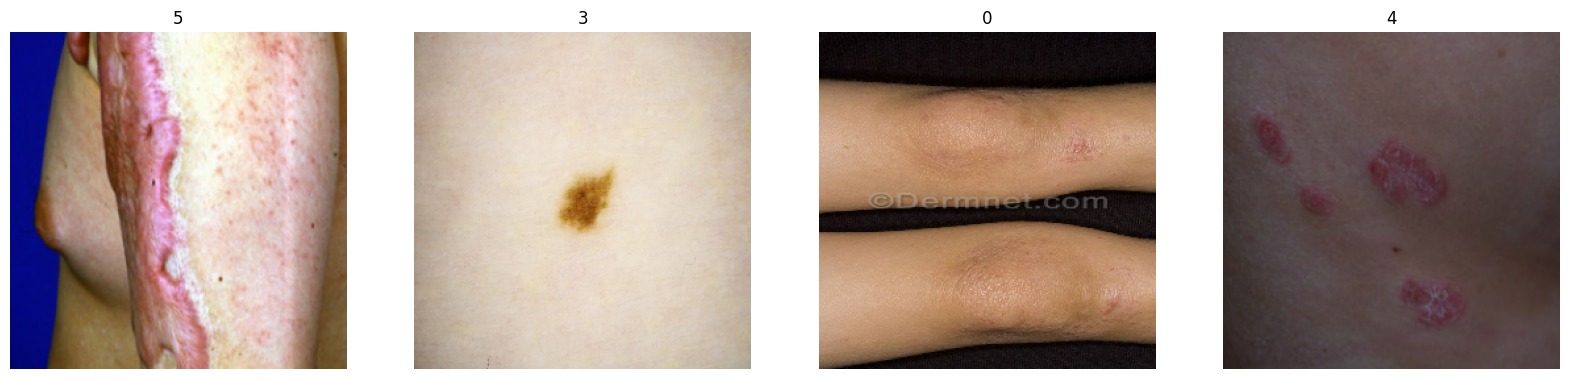

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) #creates a figure with 4 subplots
for idx, img in enumerate(batch[0][:4]): #iterates over the first 4 images in the batch
        ax[idx].imshow(img.astype('int')) #displays the image in the subplot
        ax[idx].set_title(batch[1][idx]) #sets the title of the subplot to the label of the image
        ax[idx].axis('off') #turns off the axis for the subplot

        #images in key/index 0, labels in key/index 1

Preprocessing Data

In [14]:
batch[0].max()

np.float32(255.0)

In [15]:
scaled = batch[0] / 255
scaled.max() #max value of the scaled image is 1, min value is 0

np.float32(1.0)

In [15]:
data = data.map(lambda x, y: (x / 255, y)) #scales the images to be between 0 and 1
data.as_numpy_iterator().next() #gets the next batch of data from the iterator, #accesses data pipeline


(array([[[[0.6372549 , 0.42941177, 0.35882354],
          [0.62647057, 0.41862744, 0.3480392 ],
          [0.6215686 , 0.42156863, 0.34705883],
          ...,
          [0.62058824, 0.39411765, 0.3156863 ],
          [0.6362745 , 0.4127451 , 0.3382353 ],
          [0.62352943, 0.40392157, 0.3372549 ]],
 
         [[0.62941176, 0.42156863, 0.3509804 ],
          [0.62941176, 0.42941177, 0.35490197],
          [0.6372549 , 0.4372549 , 0.3627451 ],
          ...,
          [0.6333333 , 0.40882352, 0.33039215],
          [0.63235295, 0.41470587, 0.33529413],
          [0.6343137 , 0.41862744, 0.34019607]],
 
         [[0.6362745 , 0.4362745 , 0.3617647 ],
          [0.6343137 , 0.4343137 , 0.35980392],
          [0.64215684, 0.44215685, 0.36764705],
          ...,
          [0.6480392 , 0.4245098 , 0.35392156],
          [0.6254902 , 0.40588236, 0.34117648],
          [0.60882354, 0.40098038, 0.33431372]],
 
         ...,
 
         [[0.5127451 , 0.3245098 , 0.24411765],
          [0.51862

In [16]:
scaled_iterator = data.as_numpy_iterator() #creates an iterator for the dataset, #allows us to access data pipeline
scaled_batch = scaled_iterator.next() #gets the next batch of data from the iterator, #accesses data pipeline
scaled_batch[0].max() #max value of the scaled image is 1, min value is 0

np.float32(1.0)

In [17]:
#fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) #creates a figure with 4 subplots
#for idx, img in enumerate(scaled_batch[0][:4]): #iterates over the first 4 images in the batch
        #ax[idx].imshow(img) #displays the image in the subplot
        #ax[idx].set_title(scaled_batch[1][idx]) #sets the title of the subplot to the label of the image
        #ax[idx].axis('off') #turns off the axis for the subplot

        #images in key/index 0, labels in key/index 1

Scaling Images

In [18]:
len(data)
#number of batches total, each batch has 32 images

443

In [19]:
train_size = int(len(data) * 0.7) #70% of the data is used for training #310 images per batch
val_size = int(len(data) * 0.2) #20% of the data is used for validation #88 images per batch
test_size = int(len(data) * 0.1) #10% of the data is used for testing #44 images per batch

In [20]:
test_size+val_size+train_size

442

In [21]:
train = data.take(train_size) #takes the first 70% of the data for training
val = data.skip(train_size).take(val_size) #takes the next 20% of the data for validation
test = data.skip(train_size + val_size).take(test_size) #takes the last 10% of the data for testing
len(train), len(val), len(test) #number of batches in each dataset

(310, 88, 44)

Building the Actual Models

In [22]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(0.01))) #first layer, input, 3 channels, stride of 1, 16 filters
model.add(MaxPooling2D()) #takes max values after relu activation and returns that value and condenses the information (by half)

model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=l2(0.01))) #output layer, 10 neurons, softmax activation function

c:\Users\maxkr\Desktop\Sr.Proj-STopicsS2-Proj-Code-Repo\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy']) #compiles the model, adam optimizer, binary crossentropy loss function, accuracy metric

In [25]:
model.summary() #prints the summary of the model, shows the layers, output shape, number of parameters, etc.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,698,938 (14.11 MB)

 Trainable params: 3,698,938 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

Time to Train!

In [26]:
logdir = 'logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #creates a tensorboard callback to log the training process, logs to the logdir directory

In [30]:
#Run Command
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 91s 287ms/step - accuracy: 0.3644 - loss: 1.6338 - val_accuracy: 0.5597 - val_loss: 1.1355
Epoch 2/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 97s 312ms/step - accuracy: 0.5605 - loss: 1.1408 - val_accuracy: 0.5732 - val_loss: 1.0959
Epoch 3/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 95s 305ms/step - accuracy: 0.5871 - loss: 1.0568 - val_accuracy: 0.5856 - val_loss: 1.0516
Epoch 4/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 89s 285ms/step - accuracy: 0.6368 - loss: 0.9284 - val_accuracy: 0.5863 - val_loss: 1.0611
Epoch 5/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 86s 276ms/step - accuracy: 0.6879 - loss: 0.8151 - val_accuracy: 0.5941 - val_loss: 1.0784
Epoch 6/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 104s 337ms/step - accuracy: 0.7405 - loss: 0.6782 - val_accuracy: 0.5945 - val_loss: 1.2601
Epoch 7/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 97s 314ms/step - accuracy: 0.8028 - loss: 0.5441 - val_accuracy: 0.6225 - val_loss: 1.2374
Epoch 8/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 100s 322ms/step - accuracy: 0.8483 - loss:

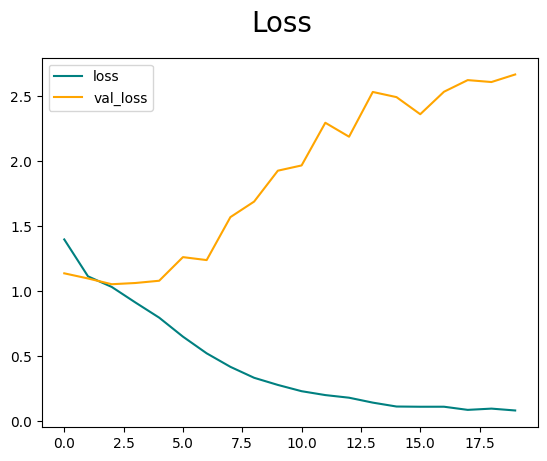

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label ='loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show() 

In [ ]:
hist.history #MODEL IS OVERFITTING ^ APPLY REGULARIZATION

{'accuracy': [0.4574596881866455,
  0.5691532492637634,
  0.598487913608551,
  0.6471773982048035,
  0.6993951797485352,
  0.7566532492637634,
  0.8151209950447083,
  0.8555443286895752,
  0.8850806355476379,
  0.9090725779533386,
  0.9303427338600159,
  0.9385080933570862,
  0.9435483813285828,
  0.9598790407180786,
  0.9670363068580627,
  0.9677419066429138,
  0.969556450843811,
  0.9764112830162048,
  0.9723790287971497,
  0.9779233932495117],
 'loss': [1.3962699174880981,
  1.1122822761535645,
  1.0307338237762451,
  0.9107924103736877,
  0.7942650318145752,
  0.6482600569725037,
  0.5199028849601746,
  0.415877103805542,
  0.33158811926841736,
  0.2766162157058716,
  0.22838547825813293,
  0.19850042462348938,
  0.17829687893390656,
  0.14044420421123505,
  0.1104620024561882,
  0.1087334081530571,
  0.10891713947057724,
  0.08465934544801712,
  0.09430402517318726,
  0.08002227544784546],
 'val_accuracy': [0.5596590638160706,
  0.5731534361839294,
  0.5855823755264282,
  0.586292

In [34]:
from tensorflow.keras.models import load_model #type: ignore
model.save(os.path.join('models', 'chairtwo.h5'))

In [17]:
new_model = load_model(os.path.join('models', 'chairtwo.h5'))

Testing 

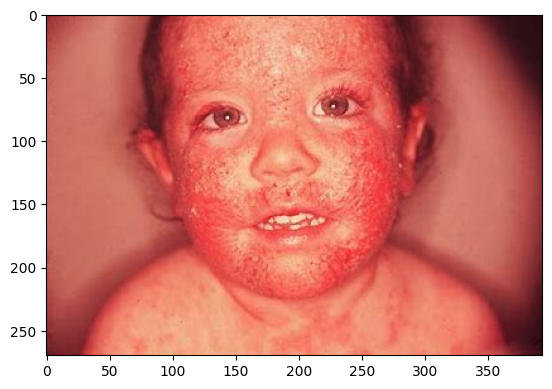

In [31]:
img = cv2.imread('AtopicTest1.jpg') #reads the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #displays the image with color conversion
plt.show() #shows the image

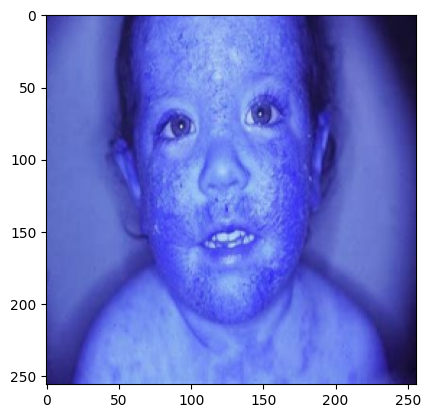

In [32]:
resize = tf.image.resize(img, (256, 256)) #resizes the image to 256x256 so the neural network can process it
plt.imshow(resize.numpy().astype(int)) #displays the image
plt.show() #shows the image

In [50]:
yhat = new_model.predict(np.expand_dims(resize/255, 0)) #predicts the class of the image, expands the dimensions to match the input shape of the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


In [51]:
yhat

array([[7.3715154e-04, 4.3448004e-01, 1.6249927e-12, 1.0211926e-07,
        3.7239677e-01, 2.3563139e-03, 1.9002959e-01, 3.8745693e-19,
        3.3392556e-21, 1.3009927e-23]], dtype=float32)

In [ ]:
# Load and preprocess the image
img_path = 'SKTest1.jpg'  # Replace with the correct path to your image, including the file extension
img = cv2.imread(img_path)  # Read the image

# Check if the image was loaded successfully
if img is None:
	raise FileNotFoundError(f"Image not found at path: {img_path}")
img_resized = tf.image.resize(img, (256, 256))  # Resize the image to match the model's input shape

# Normalize the image
img_normalized = img_resized / 255.0

# Expand dimensions to match the model's input shape
img_input = np.expand_dims(img_normalized, axis=0)

# Make predictions
predictions = new_model.predict(img_input)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


IndexError: invalid index to scalar variable.